In [1]:
#tensorboard via command-line:
#tensorboard --logdir=where your Logs directory is

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#What is the maximum flare class produced by an AR in the next 24hrs after a 24hr time sequence?
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#feature data from - hmi.sharp_720s:::
#http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm

#label data from - GOES flare events:::
#ftp://ftp.swpc.noaa.gov/pub/warehouse/

#and from - GOES XRS Report:::
#https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/xrs/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#binary class - F for flare and N for no flare
#multi-class - #6 flare classes: N is no flare, A is smallest, X is largest
               #key = {'N', 'A', 'B', 'C', 'M', 'X'}
               #['A' class flares generally not listed in official reports due to small size]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [3]:
import tensorflow as tf
print("tensorflow version:", tf.__version__) #2.3.1 used
from tensorflow import keras
import os
import glob
import shutil
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from astropy.time import Time
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN, LSTM, GRU, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import drms #https://pypi.org/project/drms/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
import Flare_Data
import Feature_Years
import Make_TB_Logs
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

tensorflow version: 2.3.1


In [4]:
Feature_Years.generate_all_feature_years()

CSVs compiled.


In [5]:
where_logs = Make_TB_Logs.make_clear_tensorboard_folder()

In [6]:
#binary = True for binary classification, binary = False for multi-class classification
X_train, X_val, X_test, y_train, y_val, y_test, tim_steps, n_feats, count_of_classes, a_encoder = Flare_Data.getAllData(binary = False)

The time series starts from:  2011-01-01 00:11:26
The time series ends on:  2016-12-31 23:47:24
(array(['B', 'C', 'M'], dtype='<U1'), array([167, 147, 155], dtype=int64))


In [7]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(300, 114, 20) (75, 114, 20) (94, 114, 20) (300, 3) (75, 3) (94, 3)


In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [9]:
batch_size = 10
epochs = 100
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-06, decay=0.0)

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[LSTM_4 Model]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Multi-Class]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Multiple Layers]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(tim_steps, n_feats)))
model.add(GaussianNoise(0.01))
model.add(Dropout(0.1))
model.add(LSTM(10, return_sequences=False))
model.add(GaussianNoise(0.01))
model.add(Dropout(0.1))
model.add(Dense(count_of_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 114, 20)           3280      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 114, 20)           0         
_________________________________________________________________
dropout (Dropout)            (None, 114, 20)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3

In [12]:
tensorboard_call = keras.callbacks.TensorBoard(log_dir=where_logs, histogram_freq=1)
#val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val), 
                    verbose=1, 
                    callbacks=[tensorboard_call]) #, val_loss_callback])

Epoch 1/100
 1/30 [>.............................] - ETA: 0s - loss: 1.1329 - categorical_accuracy: 0.0000e+00WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 6s 187ms/step - loss: 1.1039 - categorical_accuracy: 0.3167 - val_loss: 1.0976 - val_categorical_accuracy: 0.3867
Epoch 2/100
30/30 [==============================] - 1s 48ms/step - loss: 1.1020 - categorical_accuracy: 0.3500 - val_loss: 1.0970 - val_categorical_accuracy: 0.3733
Epoch 3/100
30/30 [==============================] - 1s 49ms/step - loss: 1.1011 - categorical_accuracy: 0.3433 - val_loss: 1.0961 - val_categorical_accuracy: 0.3867
Epoch 4/100
30/30 [==============================] - 1s 45ms/step - loss: 1.1038 - categorical_accuracy: 0.3433 - val_los

30/30 [==============================] - 1s 42ms/step - loss: 1.0865 - categorical_accuracy: 0.3900 - val_loss: 1.1059 - val_categorical_accuracy: 0.3600
Epoch 47/100
30/30 [==============================] - 1s 45ms/step - loss: 1.0817 - categorical_accuracy: 0.3900 - val_loss: 1.1061 - val_categorical_accuracy: 0.3733
Epoch 48/100
30/30 [==============================] - 1s 44ms/step - loss: 1.0782 - categorical_accuracy: 0.4300 - val_loss: 1.1074 - val_categorical_accuracy: 0.4000
Epoch 49/100
30/30 [==============================] - 2s 50ms/step - loss: 1.0728 - categorical_accuracy: 0.4100 - val_loss: 1.1080 - val_categorical_accuracy: 0.3733
Epoch 50/100
30/30 [==============================] - 1s 44ms/step - loss: 1.0766 - categorical_accuracy: 0.4100 - val_loss: 1.1091 - val_categorical_accuracy: 0.3600
Epoch 51/100
30/30 [==============================] - 1s 48ms/step - loss: 1.0759 - categorical_accuracy: 0.3733 - val_loss: 1.1100 - val_categorical_accuracy: 0.3600
Epoch 52/10

30/30 [==============================] - 1s 44ms/step - loss: 1.0392 - categorical_accuracy: 0.4533 - val_loss: 1.1463 - val_categorical_accuracy: 0.3733
Epoch 96/100
30/30 [==============================] - 1s 40ms/step - loss: 1.0252 - categorical_accuracy: 0.4800 - val_loss: 1.1541 - val_categorical_accuracy: 0.3600
Epoch 97/100
30/30 [==============================] - 1s 38ms/step - loss: 1.0448 - categorical_accuracy: 0.4500 - val_loss: 1.1602 - val_categorical_accuracy: 0.3733
Epoch 98/100
30/30 [==============================] - 1s 40ms/step - loss: 1.0326 - categorical_accuracy: 0.4867 - val_loss: 1.1470 - val_categorical_accuracy: 0.3867
Epoch 99/100
30/30 [==============================] - 1s 39ms/step - loss: 1.0406 - categorical_accuracy: 0.4567 - val_loss: 1.1496 - val_categorical_accuracy: 0.4000
Epoch 100/100
30/30 [==============================] - 1s 39ms/step - loss: 1.0466 - categorical_accuracy: 0.4767 - val_loss: 1.1438 - val_categorical_accuracy: 0.3733


In [14]:
#evaluate model on test set
results = model.evaluate(X_test, y_test, batch_size=1, verbose=1)
print("test loss, test acc:", results)

94/94 [==============================] - 1s 8ms/step - loss: 1.1373 - categorical_accuracy: 0.3298
test loss, test acc: [1.137316346168518, 0.3297872245311737]


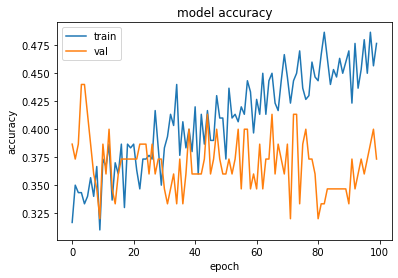

In [15]:
#summarize history for accuracy
plt.plot(history.history[(list(history.history.keys())[1])])
plt.plot(history.history[(list(history.history.keys())[3])])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

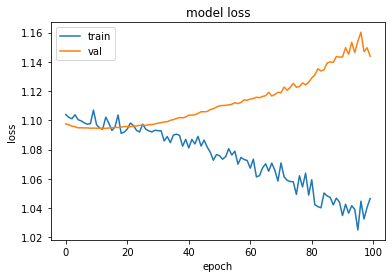

In [16]:
#summarize history for loss
plt.plot(history.history[(list(history.history.keys())[0])])
plt.plot(history.history[(list(history.history.keys())[2])])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
#generate predictions
predictions = model.predict(X_test)
print("predictions:", predictions)

predictions: [[0.31856725 0.40770498 0.27372783]
 [0.25321144 0.26928312 0.47750542]
 [0.21227123 0.2867972  0.5009316 ]
 [0.26369074 0.25622892 0.48008028]
 [0.5155193  0.23720716 0.2472736 ]
 [0.2416226  0.29740056 0.46097687]
 [0.33576927 0.28654614 0.37768462]
 [0.5363167  0.23753673 0.22614655]
 [0.47640955 0.22996187 0.29362863]
 [0.3838107  0.36143947 0.25474983]
 [0.44115525 0.24537861 0.31346616]
 [0.43162555 0.23466134 0.3337131 ]
 [0.393113   0.41484377 0.19204323]
 [0.39754274 0.3952331  0.20722419]
 [0.2878376  0.34113935 0.37102303]
 [0.39247668 0.31028277 0.29724059]
 [0.19545223 0.35755438 0.4469934 ]
 [0.18685526 0.33381155 0.47933313]
 [0.5014664  0.21719924 0.2813344 ]
 [0.3204362  0.2890814  0.39048234]
 [0.32797107 0.41940558 0.25262338]
 [0.47917718 0.32397997 0.19684286]
 [0.20311926 0.2674467  0.529434  ]
 [0.2851671  0.25949788 0.45533502]
 [0.29345042 0.27599967 0.43054995]
 [0.4191069  0.31554553 0.26534757]
 [0.5861239  0.26824152 0.14563458]
 [0.175123   0.

In [18]:
#remove encoding
real_predictions_B = a_encoder.inverse_transform(predictions)
print(real_predictions_B)

['C' 'M' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'C' 'B' 'M' 'B' 'M' 'M'
 'B' 'M' 'C' 'B' 'M' 'M' 'M' 'B' 'B' 'M' 'C' 'B' 'C' 'M' 'M' 'B' 'M' 'C'
 'B' 'B' 'B' 'B' 'B' 'M' 'C' 'C' 'C' 'M' 'M' 'M' 'B' 'C' 'B' 'M' 'B' 'M'
 'M' 'M' 'C' 'C' 'M' 'B' 'C' 'M' 'C' 'B' 'B' 'C' 'M' 'M' 'B' 'C' 'C' 'M'
 'B' 'B' 'B' 'M' 'B' 'B' 'M' 'C' 'C' 'M' 'B' 'M' 'M' 'M' 'B' 'M' 'B' 'B'
 'M' 'C' 'M' 'M']


In [19]:
#prediction counts
unique, counts = np.unique(real_predictions_B, return_counts=True)
dict(zip(unique, counts))

{'B': 35, 'C': 20, 'M': 39}

In [20]:
#y_test predictions
ytest_predictions = a_encoder.inverse_transform(y_test)
print(ytest_predictions)

['C' 'C' 'C' 'M' 'B' 'M' 'B' 'C' 'B' 'M' 'B' 'B' 'M' 'M' 'C' 'C' 'B' 'B'
 'C' 'B' 'M' 'C' 'B' 'M' 'B' 'B' 'C' 'C' 'M' 'B' 'B' 'M' 'M' 'C' 'M' 'M'
 'M' 'M' 'M' 'M' 'B' 'B' 'B' 'B' 'C' 'B' 'M' 'B' 'M' 'C' 'B' 'M' 'B' 'C'
 'C' 'M' 'C' 'C' 'C' 'B' 'M' 'C' 'B' 'M' 'C' 'B' 'B' 'M' 'M' 'M' 'B' 'C'
 'B' 'C' 'M' 'C' 'C' 'C' 'C' 'B' 'M' 'M' 'B' 'B' 'C' 'M' 'C' 'C' 'M' 'B'
 'B' 'B' 'B' 'M']


In [21]:
#real count
unique, counts = np.unique(ytest_predictions, return_counts=True)
dict(zip(unique, counts))

{'B': 34, 'C': 29, 'M': 31}

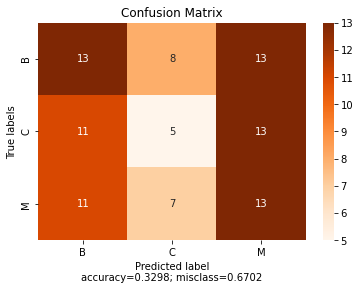

In [22]:
#confusion matrix
matrix = confusion_matrix(ytest_predictions, real_predictions_B)
#format confusion matrix
ax=plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Oranges', fmt='g');
accuracy = np.trace(matrix) / np.sum(matrix).astype('float')
misclass = 1 - accuracy
ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass));
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(unique); ax.yaxis.set_ticklabels(unique);

In [23]:
print(classification_report(ytest_predictions, real_predictions_B))

              precision    recall  f1-score   support

           B       0.37      0.38      0.38        34
           C       0.25      0.17      0.20        29
           M       0.33      0.42      0.37        31

    accuracy                           0.33        94
   macro avg       0.32      0.32      0.32        94
weighted avg       0.32      0.33      0.32        94



In [24]:
#macro - calculate metrics for each label, and find their unweighted mean
pre_score = precision_score(ytest_predictions, real_predictions_B, average = "macro")
print('precision score:{:0.4f}'.format(pre_score))
recall_score_1 = recall_score(ytest_predictions, real_predictions_B, average= "macro")
print('recall score:{:0.4f}'.format(recall_score_1))
f1_score_1 = f1_score(ytest_predictions, real_predictions_B, average="macro")
print('f1 score:{:0.4f}'.format(f1_score_1))

precision score:0.3183
recall score:0.3247
f1 score:0.3174
